# Classification Predict - Climate Change

![images.jpg](images.jpg)

### Table of contents

### Problem identification

#### Background

In a [research article](https://www.barrons.com/articles/two-thirds-of-north-americans-prefer-eco-friendly-brands-study-finds-51578661728), 19,000 customers from 28 countries where given a poll to find out how individual shopping decisions are changing. Nearly 70% of consumers in the U.S. and Canada find that it is important for a company or brand to be sustainable or eco-friendly. More than a third (40%) of the respondents globally say that they are purpose-driven consumers, who select brands based on how well they align with their personal beliefs.

Many companies are built around lessening their environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received

#### Problem statement

Build a machine learning model that is able to classify whether or not an individual believes in man made climate change based on historical tweet to increase insights about customers and inform future marketing strategies.

You can find the project overview [here](https://www.kaggle.com/c/climate-change-belief-analysis/overview).

### What data do we have?

The dataset that will be used in this classification project aggregates tweets pertaining to climate change, collected between Apr 27, 2015 and Feb 21, 2018. In total, 15819 tweets are used in the dataset. The data consists of 3 columns; twitterid, sentiment and message. A description of each column in the data is given below

**Variable definitions**

| **Variable** | **Description**   |
|:------------:|:------------------|
|**tweetid**   | Twitter unique ID |
|**message**   | Tweet body        |
|**sentiment** | Sentiment of tweet|

 Each tweet is labelled as one of the following classes:

| **Class** | **Description** |
|:---------:|:----------------|
|   2       | **News:** the tweet links to factual news about climate change |
|   1       | **Pro:** the tweet supports the belief of man-made climate change |
|   0       | **Neutral:** the tweet neither supports nor refutes the belief of man-made climate change |
|  -1       | **Anti:** the tweet does not believe in man-made climate change |

### Install necessary packages

In [ ]:
# Install necessary packages
# !pip install comet_ml

In [1]:
!pip install seaborn

In [2]:
!pip install wordcloud

In [3]:
!pip install emoji

In [4]:
!pip install pyspellchecker

In [5]:
!pip install ftfy

In [ ]:
nltk.download('punkt')

### Start experiment

In [ ]:
# from comet_ml import Experiment

In [ ]:
# Setting the API key (saved as environment variable)
# experiment = Experiment(api_key="upOwchWrd7H1e6VEnWKW7PSvz", project_name="classification-predict", workspace="team-rm1")

### Import libraries

In [7]:
# Basic libraries
import numpy as np
import pandas as pd

# Libraries for visualisations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Libraries for preprocessing
import re
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
import emoji
from ftfy import fix_text
from spellchecker import SpellChecker 
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import itertools
from sklearn.model_selection import train_test_split

# Libraries for fitting models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Library for hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# Libraries for evaluating model accuracy
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Libraries for saving models
import pickle

### Import data

In [8]:
df_test = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/test.csv')
df_train = pd.read_csv('https://raw.githubusercontent.com/Amogelang20/RM1_classification_predict/dev/train.csv')

In [9]:
# Import training dataset
df_train.set_index('tweetid',inplace = True)
df_train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [10]:
# Import testing dataset
df_test.set_index('tweetid',inplace = True)
df_test.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \r\nPu...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


### Exploratory data analysis

Let's first get quick overview of the dataset we will be working with throughout the notebook. Below is a list of all columns with their data types and the number of non-null values present in each column.

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15819 entries, 625221 to 806319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
dtypes: int64(1), object(1)
memory usage: 309.0+ KB


There are only two columns present in the training dataset; the label variable we want to classify to (`'sentiment'`), and the feature we will use to make this classification (`'message'`). We initially had a third column (`'tweetid'`) but set this column to be the index of the dataset.  The dataset contains no null entries, and the data types for (`'sentiment'`) and (`'message'`) are integer and object respectively. 

Next we will have a look at the different labels we will be classifying to.

In [12]:
df_train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

The label has four different classes, each described further in the following table:  

|Class|Tag|Description|  
|:---:|:---:|:---|  
|**-1**|**Anti**|The tweet does not believe in man-made climate change|  
|**0**|**Neutral**|The tweet neither supports nor refuses the belief of man-made climate change|   
|**1**|**Pro**|The tweet supports the belief of man-made climate change|   
|**2**|**News**|The tweet links to factual news about climate change|  

Let us have a look at the data associated with each class.

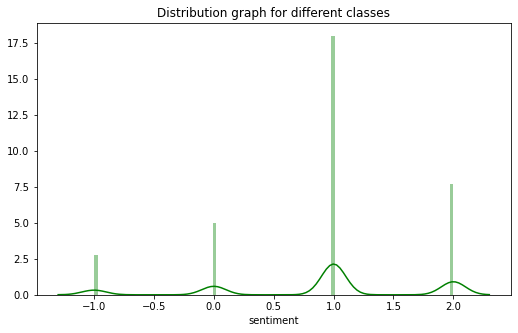

In [13]:
plot1 = plt.figure(figsize=(8.5,5))
sns.distplot(df_train['sentiment'],
             color='g',kde_kws={'bw':0.1}, bins=100, hist_kws={'alpha': 0.4})
plt.title('Distribution graph for different classes');

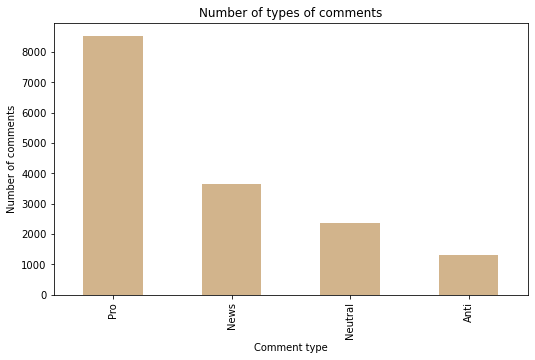

In [15]:
plot2 = plt.figure(figsize=(8.5,5))
df_train['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts().plot(kind='bar',figsize=(8.5,5), color='tan');
plt.title('Number of tweets in each sentiment class');
plt.xlabel('Sentiment class');
plt.ylabel('Number of tweets');

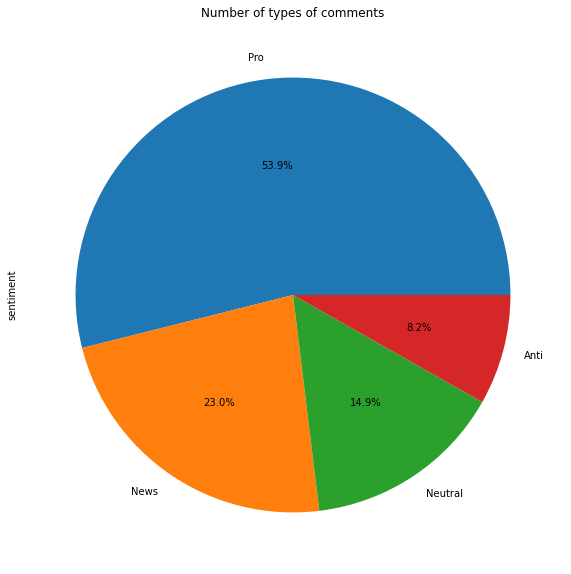

In [41]:
plot3 = plt.figure(figsize=(10,10))
names = ['Pro','News','Neutral','Anti']
df_train['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts().plot(kind='pie', labels=names, autopct='%1.1f%%');
plt.title('Number of tweets in each sentiment class');

Examining the plots reveal that the majority of the tweets(53.9%) are classified as Pro, i.e. supports the belief of man-made climate change. Since the classes are unbalanced we expect the classification algorithm to perform better when classifying larger classes ( _Pro_ ) than the smaller classes ( _News, Neutral, Anti_ ).
Unbalanced data is a problem, in that, the model might perform well in classifying the larger class but do poorly in classifying the smaller classes. In our case knowing when a tweet has a sentiment that is anti man-made climate change has an impact on how that customer may perceive a product. So if the model will mostly sentiment as pro(tweet believes in man made climate change) it could classify some of the anti as pro which gives a skewed idea about customers.

To deal with unbalanced data one can apply resampling to the classes by adjusting the number of observations in the classes. There are 3 types of resampling:

    1.Upsampling: Taking repeated random samples from the minority class until we have as many observations as the majority           class. This duplicates observations in the minority class at random
    
    2.Downsampling: Taking a random subset of the majority class small enough to match the number of observations in the             minority class. This then reduces the number of observations in the majority class.
    
    3.Both: You can apply both of these resampling methods by deciding on a class_size(usually half of major class) and               setting a threshold of 50% where classes above this threshold are downsampled and classes below this threshold are             upsampled
    
We have then created a funtion To deal with the uneven distribution of class labels. The function will modify the number of observations for a class(es) we need to resample. 

In [42]:
#Function takes in a dataframe, a class to be resampled, and a class whose observations are to be matched with.
#df is the dataframe
#class1 is the class that is to be resampled
#class2 is the class whose length is used to resample class1
def resampling(df, class1, class2):
    df_class1= df[df.sentiment==class1]
    df_class2 = df[df.sentiment==class2]
    df_new= df[df.sentiment!=class1]
    resampled = resample(df_class1, replace=False, n_samples=len(df_class2), random_state=27)
    df_resampled = pd.concat([resampled, df_new])    
    return df_resampled

Let us have a look at the most common words associated with each class.

In [43]:
df_Pro = df_train[df_train.sentiment==1]
df_News=df_train[df_train.sentiment==2]
df_Neutral=df_train[df_train.sentiment==0]
df_Anti=df_train[df_train.sentiment==-1]

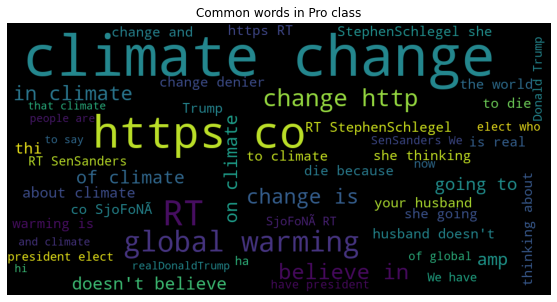

In [44]:
k= (' '.join(df_Pro['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(k)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Pro class');

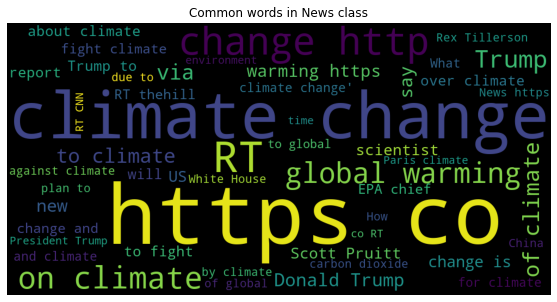

In [45]:
l= (' '.join(df_News['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(l)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in News class');

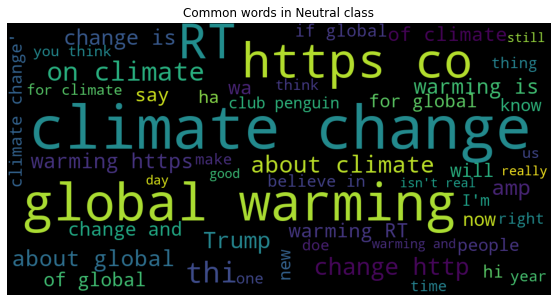

In [46]:
m= (' '.join(df_Neutral['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(m)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Neutral class');

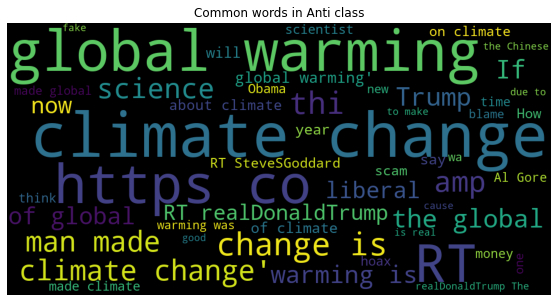

In [47]:
n= (' '.join(df_Anti['message']))

wordcloud = WordCloud(width = 1000, height = 500,max_words=50).generate(n)
plt.figure(figsize=(15,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Common words in Anti class');

From these word clouds we can see some of the most common words used in each class

### Preprocessing

The `message` column is in its raw form and needs to be cleaned for the model to be able to better process, analyze and provide predictions for sentiments. We will start off by detecting and handling missing values.

**Missing values**

In [48]:
print(df_train.isnull().sum())

sentiment    0
message      0
dtype: int64


There are no missing entries present in the training set. But since an empty string for tweets can also be considered as a missing entry, we need to check for empty strings in the `message` column as well.

In [49]:
# Checking for empty strings
blanks = [i for i,lb,tweet in df_train.itertuples() if type(tweet) == str if tweet.isspace()]
blanks

[]

The list is empty, indicating that there are no empty strings and therefore no missing values present in the dataset.  

Another thing we need to look out for are duplicates. A large amount of duplicates in the data tend to increase the bias of the estimated coefficients and standard errors of the model.

**Duplicates**

In [50]:
# Checking for duplicates in tweets
df_train[df_train.duplicated(subset='message') == True].count()/len(df_train)*100

sentiment    10.051204
message      10.051204
dtype: float64

Roughly 10% of the tweets seem to be duplicated tweets but with different ID's. Since we don't have a significantly large amount of data we will keep these duplicates and later check the impact they have when fitting the models.  

After checking for missing values and duplicates we can now move on to cleaning out text data. First we'll extract some extra features that could possibly improve our model's predicting accuracy.

**Extra feature extraction**

The first feature we will extract is the sentiment of a tweet using python's VADER library. This feature could be useful since we would expect tweets classified as `Anti` to have a more negative tone than tweets classified as `Pro`. We'll start by writing a function that takes a text string as input and determines its sentiment, i.e. negative, positive or neutral. Since these tweets do not have a wide range when it comes to sentiment scores (rarely more than 0.4) we decided to classify all tweets with scores of less than -0.05 as negative, scores between -0.05 and 0.05 where classified as neutral and a score of more than 0.05 indicated a positive tweet.

In [51]:
# Function to extract sentiment
def sentiment_score(text):
    """ A function that determines the sentiment of a text string.

        Parameters
        ----------
        text: Text string.

        Returns
        -------
        sentiment:  String indicating the sentiment of the input string.
    """
    
    sid = SentimentIntensityAnalyzer()
    s = sid.polarity_scores(text)['compound']
    if s<-0.05:
        sentiment='negative'
    elif s>0.05:
        sentiment='positive'
    else:
        sentiment='neutral'
    
    return sentiment

Twitter handles could be a second useful feature. Sentiment will help us a lot with classifying classes like `Anti`, `Neutral` and `Pro`, but we would find it more difficult to classify `News` using these sentiments. Twitter handles could help the model distinguish between the `News` class and the other classes. We assume that tweets classified as `News` would've probably been extracted from news accounts and therefore have news related handles.  

We now extract all **unique** Twitter handles found in tweets within the `News` class.

In [52]:
# Extract all unique news related handles into a list
n_temp = [re.findall(r'@[\w]+',df_train['message'].iloc[i]) for i,x in enumerate(df_train['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]
news = list(set(itertools.chain.from_iterable(news)))

In [56]:
news[-5:]

['@Breaking911', '@telesurenglish', '@MichaelReschke', '@NewYorker', '@POTUS']

Looking at the last 5 entries inside our list we see our hunch was correct. We see news channels and magazines like `@Breaking911` and `@NewYorker`. There are also handles from influential people like `@MichaelReschke`, a journalist for The Herald-Times, and `@POTUS` who would be the president of the United States.  

We have now created our features and move on to cleaning the text data.

**Hashtags**

`#Hashtags` are used to make a statement about something, or to start a conversation around a specific topic or trend. In twitter data a lot of hashtags are generally used and may contain viable information that indicate a certain sentiment towards a specific topic. However, hashtags are a compressed set of words or sentences and since they are recorded as 1 word it may be hard for the model to decipher them. For this reason a dictionary,`hashtags`, with all the possible hashtags about climate change has been created with the corresponding decompressed words.

_These files are then modified further outside jupyter notebook._ 

**DO NOT RUN THIS CODE(below)** IT IS JUST FOR ILLUSTRATION OF PROCESS TAKEN.

In [ ]:
####################################################################################################################

hashtags = df_train['message'].apply(lambda x: re.findall(r'[#]\\w+',x))
# Extracting all unique hashtags
hashtags = list(set([item for sublist in hashtags for item in sublist])) 
# Exporting twice. One is used for the keys in the dictionary and the other is used for values(separated words).
with open('hash_file', 'wb') as fp:
    pickle.dump(hashtags, fp)
with open('hash_file_clean', 'wb') as fp:
    pickle.dump(itemlist, fp)
    
####################################################################################################################

After modifying these files we will load them back into the notebook to help with preprocessing the text data.

In [58]:
# Read in created hashtag text file and create a hashtags dictionary

# Keys
hash_file = [line.rstrip('\n') for line in open('hash_file.txt')]
hash_file = [i.center(len(i)+2) for i in hash_file]

# Values
hash_file_clean = [line.rstrip('\n') for line in open('hash_file_clean.txt')] 
hash_file_clean = [i.center(len(i)+2) for i in hash_file_clean]

hashtags = {hash_file[i]: hash_file_clean[i] for i in range(len(hash_file))} 

Next we write a function to expand hashtags inside the text data into seperate words.

In [59]:
# Substitute hastags with separated words
def expand_hashtags(df,column_name):
    """ A funtion that expands the hashtag words into separate words.

        Parameters
        ----------
        df:          Dataframe containing the text column to be transformed.
        column_name: Name of the column containing the text data.

        Returns
        -------
        df:  Dataframe containg the updated text column
        
        Example
        -------
        #iamgreat returns 'i am great'
    """
    
    df[column_name] = df[column_name].str.lower()
    for word in hashtags.keys():
            df[column_name] = df[column_name].apply(lambda x: re.sub(word,hashtags[word],x))
    return df

In [ ]:
df_train = expand_hashtags(df_train,'message')

**Contractions**

The `message` column contains some contracted words such as *can't* and *don't*. As part of the cleaning process these words will be replaced with their expanded words that don't contain any omission. We do this because we will later tokenize the text. We assume that a model would have an easier time using tokens like `can` and `not` than `can` and `'t`. A dictionary `contractions` is created with possible contractions and their corresponding full words.

In [60]:
# Dictionary of contracted words
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

Now let's replace the contracted words by their expanded alternatives.

In [62]:
# Replace contracted words with full word
df_train['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) for raw in df_train['message']]


**Lowercase**

To help our model, we will be converting all text to lowercase. We will work with lower cased data to remove noise from capitalised words as the computer may see uppercased words as different from lower cased words. If this transformation is not applied we run the risk of the model possibly classifying cases like `Snowball` and `snowball` differently. By transforming we help the model understand that those two word are in fact the same.

In [63]:
# Lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
df_train['message'] = df_train['message'].str.lower()


**Encoding**

Tweet data can also include bad unicode. For example, where a person wants so say `José Florés` or use a `(—)`, it ends up being `JosÃ© Florés` or `â€”` instead. These issues can make it hard for the model to process the data. There is a package in python that takes care of these issues for us. The ftfy(fixed this for you package) takes all the bad unicode and outputs the good unicode. So let's let the package fix these problems for us.

In [64]:
df_train['message'] = df_train['message'].apply(lambda x: fix_text(x))


**URLs**

We won't be using any urls. Since urls tend to be unique and random for any class, they do not really add explanatory power and will therefore be removed.

In [65]:
# Removing urls
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'https\S+','url',x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'www\S+', 'url',x))


**Emojis**

The `message` column may also contain emojis, ex. 👨🏽‍💻. As we can see, alone they're just symbols and don't have a word association to them. This makes them hard to interpret. Emojis could be usefull in the modeling process, so we'll be replacing them with the word that describes them.

In [66]:
# Replace emojis with their word meaning
df_train['message'] = df_train['message'].apply(lambda x: emoji.demojize(x))


**Shortened words/Slang**

With tweets data a lot of shortened words like *abt* are used instead of the full words *about*. This can make it difficult for the model to process these words. We will replace the shortened words with their corresponding full word. A dictionary of possible shortened words and their corresponding full words is given below.

In [67]:
# Replace shortened words with full words
short = {' BD ': ' Big Deal ',
 ' abt ':' about ',
 ' ab ': ' about ',
 ' fav ': ' favourite ',
 ' fab ': ' fabulous ',
 ' smh ': ' shaking my head ',
 ' u ': ' you ',
 ' c ': ' see ',
 ' anon ': ' anonymous ',
 ' ac ': ' aircon ',
 ' a/c ': ' aircon ',
 ' yo ':' year old ',
 ' n ':' and ',
 ' nd ':' and ',
 ' 2 ': ' to ',
 ' w ': ' with ',
 ' w/o ': ' without ',
 ' r ': ' are ',
 ' rip ':' rest in peace ',
 ' 4 ' : ' for ',
' BF ': ' Boyfriend ',
' BRB ': ' Be Right Back ',
' BTW ': ' By The Way ',
' GF ': ' Girlfriend ',
' HBD ': ' Happy Birthday ',
' JK ': ' Just Kidding ',
' K ':' Okay ',
' LMK ': ' Let Me Know ',
' LOL ': ' Laugh Out Loud ',
' HA ':' laugh ',
' MYOB ': ' Mind Your Own Business ',
' NBD ': ' No Big Deal ',
' NVM ': ' Nevermind ',
' Obv ':' Obviously ',
' Obvi ':' Obviously ',
' OMG ': ' Oh My God ',
' Pls ': ' Please ',
' Plz ': ' Please ',
' Q ': ' Question ', 
' QQ ': ' Quick Question ',
' RLY ': ' Really ',
' SRLSY ': ' Seriously ',
' TMI ': ' Too Much Information ',
' TY ': ' Thank You, ',
' TYVM ': ' Thank You Very Much ',
' YW ': ' You are Welcome ',
' FOMO ': ' Fear Of Missing Out ',
' FTFY ': ' Fixed This For You ',
' FTW ': ' For The Win ',
' FYA ': ' For Your Amusement ',
' FYE ': ' For Your Entertainment ',
' GTI ': ' Going Through It ',
' HTH ': ' Here to Help ',
' IRL ': ' In Real Life ',
' ICYMI ': ' In Case You Missed It ',
' ICYWW ': ' In Case You Were Wondering ',
' NBC ': ' Nobody Cares Though ',
' NTW ': ' Not To Worry ',
' OTD ': ' Of The Day ',
' OOTD ': ' Outfit Of The Day ',
' QOTD ': ' Quote of the Day ',
' FOTD ': ' Find Of the Day ',
' POIDH ': ' Pictures Or It Did ntt Happen ',
' YOLO ': ' You Only Live Once ',
' AFAIK ': ' As Far As I Know ',
' DGYF ': ' Dang Girl You Fine ',
' FWIW ': ' For What It is Worth ',
' IDC ': ' I Do not Care ',
' IDK ': ' I Do not Know ',
' IIRC ': ' If I Remember Correctly ',
' IMHO ': ' In My Honest Opinion ',
' IMO ': ' In My Opinion ',
' Jelly ': ' Jealous ',
' Jellz ': ' Jealous ',
' JSYK ': ' Just So You Know ',
' LMAO ': ' Laughing My Ass Off ',
' LMFAO ': ' Laughing My Fucking Ass Off ',
' NTS ': ' Note to Self ',
' ROFL ': ' Rolling On the Floor Laughing ',
' ROFLMAO ': ' Rolling On the Floor Laughing My Ass Off ',
' SMH ': ' Shaking My Head ',
' TBH ': ' To Be Honest ',
' TL;DR ':  ' Too Long; Did not Read ',
' TLDR ':  ' Too Long; Did not Read ',
' YGTR ': ' You Got That Right ',
' AYKMWTS ': ' Are You Kidding Me With This Shit ',
' BAMF ': ' Bad Ass Mother Fucker ',
' FFS ': ' For Fuck Sake ',
' FML ': ' Fuck My Life ',
' HYFR ': ' Hell Yeah Fucking Right ',
' IDGAF ': ' I Do not Give A Fuck ',
' NFW ': ' No Fucking Way ',
' PITA ': ' Pain In The Ass ',
' POS ': ' Piece of Shit ',
' SOL ': ' Shit Outta Luck ',
' STFU ': ' Shut the Fuck Up ',
' TF ': ' The Fuck ',
' WTF ': ' What The Fuck ',
' BFN ': ' Bye For Now ',
' CU ': ' See You ',
' IC ': ' I see ',
' CYL ': ' See You Later ',
' GTG ': ' Got to Go ',
' OMW ': ' On My Way ',
' RN ': ' Right Now ',
' TTYL ': ' Talk To You Later ',
' TYT ': ' Take Your time ',
' CC ': ' Carbon Copy ',
' CX ': ' Correction ',
' DM ': ' Direct Message ',
' FB ': ' Facebook ',
' FBF ': ' Flash-Back Friday ',
' FF ': ' Follow Friday ',
' HT ': ' Tipping my hat ',
' H/T ': ' Tipping my hat ',
' IG ': ' Instagram ',
' Insta ': ' Instagram ',
' MT ':' Modified Tweet ',
' OH ': ' Overheard ',
' PRT ': ' Partial Retweet ',
' RT ': ' Retweet ',
'rt ' : ' retweet ',
' SO ':' Shout Out ',
' S/O ': ' Shout Out ',
' TBT ': ' Throw-Back Thursday ',
' AWOL ': ' Away While Online ',
' BFF ': ' Best Friend Forever ',
' NSFW ': ' Not Safe For Work ',
' OG ': ' Original Gangster ',
' PSA ': ' Public Service Announcement ',
' PDA ': ' Public Display of Affection '}

short = dict((key.lower(), value.lower()) for key,value in short.items())

Now let's replace the shortened words by their full alternatives.

In [68]:
# Replacing shortened words with full words
for word in short.keys():
    df_train['message'] = df_train['message'].apply(lambda x: re.sub(word,short[word],x))


**News handles**

Here is where we will now use our first created feature. We hope that by removing all handles that are **not** news related, we are helping the model distinguish between news and non news tweets. Where news related handles can be found inside our `news` list we created earlier.

In [69]:
# Remove twitter non news related handles and @ symbol
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'@','', ' '.join([y for y in x.split() if y not in [z for z in re.findall(r'@[\w]*',x) if z not in news]])))


**Punctuation**

Other than with sentiment analysis, where some punctuation is useful, punctuations and numbers tend to be rendered useless in modeling. As the symbols aren't specific to certain classes, they add no explanatory power and can therefore be removed. We will however not be removing exclamation marks, since they are of great value during sentiment analysis.

In [70]:
# Remove punctuation (except ! for sentiment analysis)
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r"[^A-Za-z! ]*",'',x))


**Vowels repeated at least 3 times**

It is not uncommon for people to stretch words when typing. For example, instead of using `cool` the word is stretched to `cooooool`. Words are of no use to us in this form, so we wish to shrink them back to their appropriate size. We'll do this by removing any extra vowels that are repeated at least three times. Note that we are aware that words like `nooooo` should be reduced to only one vowel to result in `no`. The reason we reduce to two vowels is to reduce the probability of creating misspelled words that could mean something else in their transformed form. A good example would be `beeeee`. Where `bee` and `be` would mean two completely different things.

In [ ]:
# Remove vowels repeated at least 3 times ex. Coooool > Cool
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'([aeiou])\1+', r'\1\1', x))
df_train.head()

**Sequences indicating laughing**

It is also very common for people to express laughter in different ways. A few of these ways are in fact just a sequence of repeating letters like `haha` or `lolol`. For these sequences to add more value to our model we'll change them to the word `laugh`, which the model can easily understand.

In [ ]:
# Replace sequence of 'h' and 'a', as well as 'lol' with 'laugh'
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'ha([ha])*', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'he([he])*', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'lol([ol])*', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'lo([o])*l', r'laugh', x))
df_train.head()

**Sentiment**

Here we will use the second feature we created earlier. As explained earlier, we hope that by adding sentiment words (`negative`,`positive`,`neutral`) to the text, we are helping the model distinguish between the classes `Anti`, `Pro` and `Neutral`.

In [ ]:
# Add sentiment
df_train['message'] = df_train['message'].apply(lambda x: x + ' ' + sentiment_score(x))  
df_train.head()

**Cleaning function**

Tweets can have a lot of noise in them from the type of language, style and grammar used. All things the computer may find hard to process. These issues have to be dealt with in order for the model to be able to process the text data and make predictions. We'll write a function (`cleanup`) to apply all the necessary transformations that we applied and explained above.

In [ ]:
def cleanup(raw):
    """ A function that 'cleans' tweet data. The text gets modified by:
        - being lower cased, 
        - removing urls, 
        - removing bad unicode,
        - replacing emojis with words,
        - removing twitter non news related handles,
        - removing punctuation,
        - removing vowels repeated at least 3 times,
        - replacing sequences of 'h' and 'a', as well as 'lol' with 'laugh',
        - adding sentiment

        Parameters
        ----------
        raw: Text string.

        Returns
        -------
        raw:  Modified clean string
    """
    
    # Convert to lowercase
    raw = raw.lower()
    
    # Fix strange characters
    raw = fix_text(raw)
    
    # Removing urls
    raw = re.sub(r'https\S+','url',raw)
    raw = re.sub(r'www\S+', 'url',raw)
    
    # Replace emojis with their word meaning
    raw = emoji.demojize(raw)

    # Remove twitter non news related handles and @ symbol
    raw = ' '.join([y for y in raw.split() if y not in [x for x in re.findall(r'@[\w]*',raw) if x not in news]])
    
    # Remove punctuation (except ! for sentiment analysis)
    raw = re.sub(r"[^A-Za-z!' ]*",'',raw)
    
    # Remove vowels repeated at least 3 times ex. Coooool > Cool
    raw = re.sub(r'([aeiou])\1+', r'\1\1', raw)
    
    # Replace sequence of 'h' and 'a', as well as 'lol' with 'laugh'
    raw = re.sub(r'ha([ha])*', r'laugh', raw)
    raw = re.sub(r'he([he])*', r'laugh', raw)
    raw = re.sub(r"lol([ol])*", r'laugh', raw)
    raw = re.sub(r"lo([o])*l", r'laugh', raw)
    
    # Add sentiment
    raw = raw + ' ' + sentiment_score(raw)
    
    return raw


To be able to make somewhat accurate predictions we need to apply all the above transformations to our testing set `df_test` as well.

In [ ]:
# Replace contracted words with full word
df_test['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) for raw in df_test['message']]


In [ ]:
# Replacing shortened words with full words
for word in short.keys():
    df_test['message'] = df_test['message'].apply(lambda x: re.sub(word,short[word],x))


In [ ]:
# Apply cleaning function
df_test['message'] = df_test['message'].apply(lambda x: cleanup(x))
df_test.head()

In [ ]:
# Seperate hashtags
df_train = expand_hashtags(df_train,'message')

**Spelling**

We also check the percentage of misspelled words in the data, so we can know if this is also an issue that needs to be fixed.

In [71]:
spell = SpellChecker() 
# check for misspelled words
misspelled = df_train['message'].apply(lambda x: spell.unknown(x))
misspelled.isnull().mean()

0.0

### Split data into response and predictors

In [ ]:
y = df_train['sentiment']
X = df_train['message']

### Split data into training and validation sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Build pipelines to vectorize the data

In [ ]:
# Write class that has object that tokenizes text data AND stems the tokens
class StemAndTokenize:
    def __init__(self):
        self.ss = SnowballStemmer('english')
    def __call__(self, doc):
        return [self.ss.stem(t) for t in word_tokenize(doc)]

#### Logistic Regression

In [ ]:
# Create pipeline for Logistic Regression:
lr = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('lr', LogisticRegression())
              ])

#### Naïve Bayes

In [ ]:
# Create pipeline for Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nb', MultinomialNB())
              ])

#### Linear SVM (Support Vector Machine)

In [ ]:
# Create pipeline for SVM:
Lsvm = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('Lsvm', LinearSVC())
              ])

#### Random Forest

In [ ]:
# Create pipeline for Random Forest:
rf = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('rf', RandomForestClassifier())
              ])

#### KNN (K Nearest Neighbors)

In [ ]:
# Create pipeline for KNN:
knn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('knn', KNeighborsClassifier())
              ])

#### Neural Networks

In [ ]:
# Create pipeline for Neural Networks:
nn = Pipeline([('tfidf', TfidfVectorizer(tokenizer=StemAndTokenize())),
               ('nn', MLPClassifier())
              ])

### Hyperparameter optimization

In [ ]:
# optimize models by tuning parameters (GridSearch)


### Train models

#### Logistic Regression

In [ ]:
# Fitting the Logistic Regression model
lr.fit(X_train, y_train)

#### Naïve Bayes

In [ ]:
# Fitting the Naïve Bayes model
nb.fit(X_train, y_train)

#### Linear SVM (Support Vector Machine)

In [ ]:
# Fitting the SVM model
Lsvm.fit(X_train, y_train)

#### Random Forest

In [ ]:
# Fitting the Random Forest model
rf.fit(X_train, y_train)

#### KNN (K Nearest Neighbors)

In [ ]:
# Fitting the KNN model
knn.fit(X_train, y_train)

#### Neural Networks

In [ ]:
# Fitting the Neural Networks model
nn.fit(X_train, y_train)

### Make predictions

#### Logistic Regression

In [ ]:
# Form a prediction set for the Logistic Regression model
pred_lr = lr.predict(X_test)

#### Naïve Bayes

In [ ]:
# Form a prediction set for the Naïve Bayes model
pred_nb = nb.predict(X_test)

#### Linear SVM (Support Vector Machine)

In [ ]:
# Form a prediction set for the Linear SVM model
pred_Lsvm = Lsvm.predict(X_test)

#### Random Forest

In [ ]:
# Form a prediction set for the Random Forest model
pred_rf = rf.predict(X_test)

#### KNN (K Nearest Neighbors)

In [ ]:
# Form a prediction set for the KNN model
pred_knn = knn.predict(X_test)

#### Neural Networks

In [ ]:
# Form a prediction set for the Neural Network model
pred_nn = nn.predict(X_test)

### Evaluate model accuracy

#### Confusion Matrices

A [confusion matrix](https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62) is performance metric used in a machine learning classification problem where the output can be two or more classes. It is a table with 4 different combinations of predicted and actual values. Each block in the table is a number of those classifications made 

The table consists of 4 measures that form part of the confusion matrix:
      
- **TP(True Positive)** : You predicted positive and it’s true. Number of correctly classified positives
- **FP(False Positive)** : You predicted positive and it’s false. Number of incorrectly classified positives
- **FN(Falso Negative)** : You predicted negative and it’s false. Number of incorrectly classified negatives
- **TN(True Negative)** :  You predicted negative and it’s true. Number of correctly classified negatives

![confusionmatrix.png](confusionmatrix.png)

In [ ]:
labels = ['2: News', '1: Pro', '0: Neutral', '-1: Anti']

#### Logistic Regression

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_lr), index=labels, columns=labels)

#### Naïve Bayes

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nb), index=labels, columns=labels)

#### Linear SVM (Support Vector Machine)

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_Lsvm), index=labels, columns=labels)

#### Random Forest

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_rf), index=labels, columns=labels)

#### KNN (K Nearest Neighbors)

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_knn), index=labels, columns=labels)

#### Neural Networks

In [ ]:
pd.DataFrame(data=confusion_matrix(y_test, pred_nn), index=labels, columns=labels)

#### Classification Report

#### Logistic Regression

In [ ]:
print('Classification Report from Logistic Regression Model')
print(classification_report(y_test, pred_lr, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Naïve Bayes

In [ ]:
print('Classification Report from Naïve Model')
print(classification_report(y_test, pred_nb, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Linear SVM (Support Vector Machine)

In [ ]:
print('Classification Report from Linear SVM (Support Vector Machine) Model')
print(classification_report(y_test, pred_Lsvm, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Random Forest

In [ ]:
print('Classification Report from Random Forest Model')
print(classification_report(y_test, pred_rf, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### KNN (K Nearest Neighbors)

In [ ]:
print('Classification Report from KNN(K Nearest Neighbours) Model')
print(classification_report(y_test, pred_knn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

#### Neural Networks

In [ ]:
print('Classification Report from Neural Networks Model')
print(classification_report(y_test, pred_nn, target_names=['2: News', '1: Pro', '0: Neutral', '-1: Anti']))

In [ ]:
#Table for all models with only f1 score

In [ ]:
#lr.predict(X_test) -> use predictions created above
data = {'Model':['Logistic Regression','Naïve Bayes','Linear SVM','Random Forest','KNN','Neural Network'],
        'F1_score' :[f1_score(y_test, lr.predict(X_test)),
       f1_score(y_test, pred_lr),
       f1_score(y_test, pred_nb)
       f1_score(y_test, pred_Lsvm),
       f1_score(y_test, pred_knn),
       f1_score(y_test, pred_nn)]}

pd.DataFrame(data=data, columns=['Model F1_score'])

### Save the model

In [ ]:
model = Lsvm
model_save_path = "Linear_SVM_base_model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(model,file)

### Log parameters

In [ ]:
f1 = f1_score(y_test, pred_Lsvm, average='weighted')
recall = recall_score(y_test, pred_Lsvm, average='weighted')
precision = precision_score(y_test, pred_Lsvm, average='weighted')
accuracy = accuracy_score(y_test, pred_Lsvm)
confusion_mat = confusion_matrix(y_test, pred_Lsvm)

In [ ]:
#these will be logged to your sklearn-demos project on Comet.ml
# (FINAL MODEL after gridsearch best parms)
params={"random_state":42,
        "test_size":0.2
        "model_type":"Linear SVM"
       }

metrics = {"f1":f1,
           "recall":recall,
           "precision":precision,
           "accuracy":accuracy
            }

# exp.log_dataset_hash(X_train_scaled)
exp.log_parameters(params)
exp.log_metrics(metrics)

experiment.log_confusion_matrix(labels=['2: News', '1: Pro', '0: Neutral', '-1: Anti'],matrix=confusion_mat)

experiment.log_figure(figure=plot1,figure_name='Distribution graph for different classes')
experiment.log_figure(figure=plot2,figure_name='Number of types of comments')

experiment.log_model(name='Linear SVM - base model', file_or_folder='pickled file')

### End experiment

In [ ]:
# experiment.end()

### Conclusion